In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchtext
from torch.autograd import Variable
from torchtext.data import Field,BucketIterator

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import spacy

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_de, 
             lower=True,
             init_token = '<sos>', 
             eos_token = '<eos>'
             )
TRG = Field(tokenize = tokenize_en, 
            lower=True,
            init_token = '<sos>', 
            eos_token = '<eos>')

In [6]:
train, val, test = torchtext.datasets.Multi30k.splits(exts = ('.de', '.en'), 
                                                      fields = (SRC, TRG))

downloading training.tar.gz


.data\multi30k\training.tar.gz: 100%|██████████████████████████████████████████████| 1.21M/1.21M [00:06<00:00, 200kB/s]


downloading validation.tar.gz


.data\multi30k\validation.tar.gz: 100%|███████████████████████████████████████████| 46.3k/46.3k [00:00<00:00, 64.0kB/s]


downloading mmt_task1_test2016.tar.gz


.data\multi30k\mmt_task1_test2016.tar.gz: 100%|███████████████████████████████████| 66.2k/66.2k [00:01<00:00, 64.9kB/s]


In [9]:
SRC.build_vocab(train)
TRG.build_vocab(train)

In [10]:
train_iter, val_iter, test_iter = BucketIterator.splits(
                                  (train, val, test), batch_size=16)

In [30]:
class Encoder(nn.Module):
    """
    將欲翻譯句子轉為隱向量
    """
    
    def __init__(self, embed_dim = 128):
        super(Encoder,self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = embed_dim
        
        self.embed = nn.Embedding(len(SRC.vocab),embed_dim)
        self.rnn = nn.LSTM(embed_dim,self.hidden_dim,1)
    
    def forward(self, x):
        tmp = self.embed(x)
        tmp, (ht, ct) = self.rnn(tmp)
        return ht, ct

In [31]:
class Decoder(nn.Module):
    """
    將隱向量與目標句子轉為欲翻譯句子
    """
    
    def __init__(self, embed_dim = 128):
        super(Decoder,self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = embed_dim
        self.output_dim = len(TRG.vocab)
        
        self.embed = nn.Embedding(self.output_dim,embed_dim)
        self.rnn = nn.LSTM(embed_dim,self.hidden_dim,1)
        self.fc = nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self, x, h, c):
        tmp = x.unsqueeze(0)
        tmp = self.embed(tmp)
        tmp, (h, c) = self.rnn(tmp, (h, c))
        tmp = tmp.squeeze(0)
        tmp = self.fc(tmp)
        return tmp, h, c

In [32]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        trg_len, batch_size = trg.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).cuda()
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [18]:
enc = Encoder().cuda()
dec = Decoder().cuda()
model = Seq2Seq(enc,dec).cuda()

In [ ]:
## 測試 forward
for i in train_iter:
    text = i.src
    label = i.trg
    output = model(text,label)
    print(output.shape)
    break

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi[TRG.pad_token])
optim = torch.optim.Adam(model.parameters())

In [33]:
epoches = 10

In [34]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.src.cuda()
        label = data.trg.cuda()
        
        output = model(text,label)
        
        output = output[1:].view(-1, output.shape[-1])
        label = label[1:].view(-1)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optim.step()
        
        output = output.detach().cpu()
        text = text.detach().cpu()
        label = label.detach().cpu()
        
        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

  0%|                                                                                 | 2/1813 [00:00<02:03, 14.71it/s]

epoch 1 : 0.2560454741921918


  0%|                                                                                 | 2/1813 [00:00<02:01, 14.93it/s]

epoch 2 : 0.2371128207157398


  0%|                                                                                 | 2/1813 [00:00<02:12, 13.70it/s]

epoch 3 : 0.22336561082971507


  0%|                                                                                 | 2/1813 [00:00<02:10, 13.89it/s]

epoch 4 : 0.21276846999957644


  0%|                                                                                 | 2/1813 [00:00<01:45, 17.24it/s]

epoch 5 : 0.20422995005804917


  0%|                                                                                 | 2/1813 [00:00<01:49, 16.53it/s]

epoch 6 : 0.19617808093695804


  0%|                                                                                 | 2/1813 [00:00<02:43, 11.05it/s]

epoch 7 : 0.18910529427692807


  0%|                                                                                 | 2/1813 [00:00<02:11, 13.79it/s]

epoch 8 : 0.18321211649631633


  0%|                                                                                 | 2/1813 [00:00<02:06, 14.29it/s]

epoch 9 : 0.1780278966467956


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [01:38<00:00, 18.47it/s]

epoch 10 : 0.17162103613902782


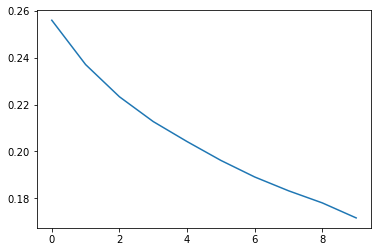

In [35]:
plt.plot(training_loss)

In [86]:
model.eval()
with torch.no_grad():
    for index, data in enumerate(train_iter):
        text = data.src.cuda()
        label = data.trg.cuda()
        
        output = model(text, label, 0)
        output = output.detach().cpu()
        output = output.argmax(dim=2).transpose(0,1).numpy()
        output = [[TRG.vocab.itos[i] for i in o] for o in output]
        for z in output:
            print(' '.join(z))
        if index > 1:
            break

<unk> two people stand in front of a building with two two men with graffiti . <eos> <eos> . <eos> <eos>
<unk> a woman is on a a . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
<unk> a little girl with a pink pink sits on a beach with her . <eos> <eos> <eos> <eos> <eos> <eos>
<unk> a boy playing in a a game . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
<unk> two girls are sitting on a table . <eos> <eos> . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
<unk> a woman and children are standing on the sidewalk with a a on a a . . <eos> <eos> <eos>
<unk> a cowboy is a a a a a a a a a a a a a a a . .
<unk> a girl is on a a and a and and the other is on her . . <eos> <eos> <eos>
<unk> five young adults are having fun in a a in a room . <eos> <eos> <eos> <eos> <eos> <eos> <eos>
<unk> men are two men in two men are standing in the . . <eos> <eos> <eos> <eos> <eos> <eos> <eos>
<unk> a woman with a white hat and a stands in front

In [87]:
torch.save(model.state_dict(),'seq2seq.pth')

In [ ]:
model.load_state_dict(torch.load('seq2seq.pth'))